In [ ]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 1. Add project root to path
# This allows us to import from 'src' even though we are in 'notebooks'
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# 2. Import project modules
from src.data.partition import partition_data

print(f"✅ Project Root set to: {PROJECT_ROOT}")

✅ Project Root set to: /home/e20094/e20-4yp-backdoor-resilient-federated-nids


In [2]:
def visualize_partition(dataset, partitions, num_classes=10, title="Data Distribution"):
    """
    Plots a stacked bar chart showing how classes are distributed across clients.
    """

    labels = dataset.tensors[1].numpy() # TensorDataset

    # 2. Setup Data Matrix (Rows=Clients, Cols=Classes)
    n_clients = len(partitions)
    client_ids = range(n_clients)
    class_counts = np.zeros((n_clients, num_classes))

    # 3. Fill Matrix
    for cid, indices in partitions.items():
        if len(indices) == 0: continue
        client_labels = labels[indices]
        counts = Counter(client_labels)
        for cls, count in counts.items():
            class_counts[cid, cls] = count

    # 4. Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(n_clients)
    
    # Use a distinct colormap
    colors = plt.get_cmap('tab10')

    for cls in range(num_classes):
        ax.bar(client_ids, class_counts[:, cls], bottom=bottom, 
               label=f'Class {cls}', color=colors(cls), alpha=0.9)
        bottom += class_counts[:, cls]

    # 5. Formatting
    ax.set_xlabel('Client ID', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(client_ids)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Legend outside the plot
    ax.legend(title="Attack Class", bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

📂 Loading data from: /home/e20094/e20-4yp-backdoor-resilient-federated-nids/data/unsw-nb15/processed/train_pool.pt
Generating IID Partition...
🔪 Partitioning 206138 samples for 10 clients (Method: iid)...


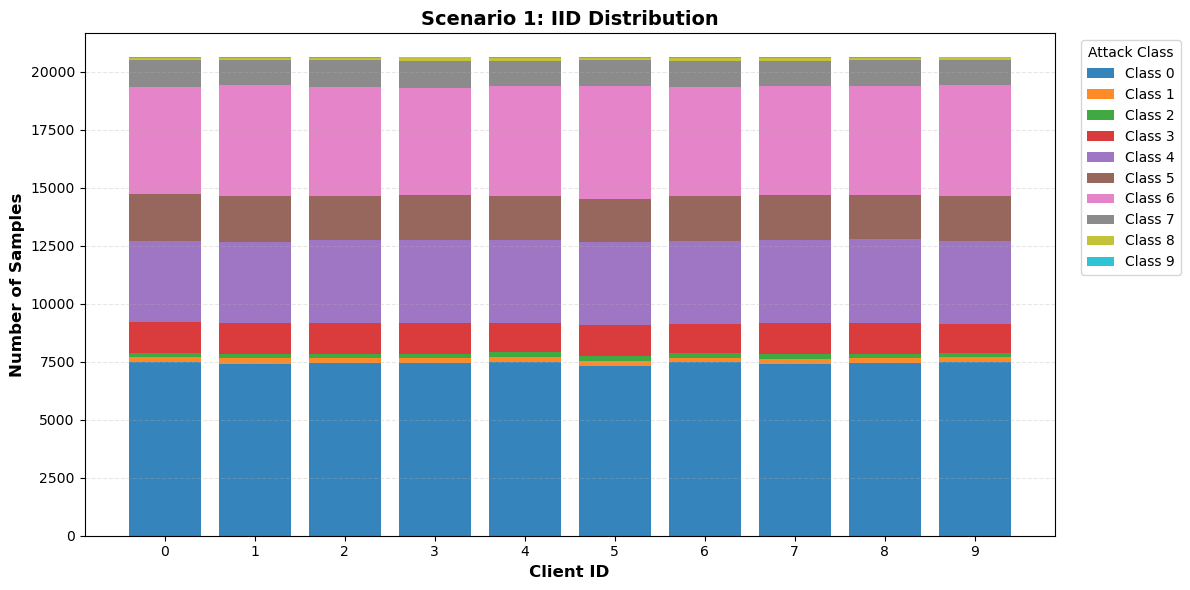

In [3]:
# Path to your processed data
data_path = os.path.join(PROJECT_ROOT, "data/unsw-nb15/processed/train_pool.pt")

# Load the dictionary payload
print(f"📂 Loading data from: {data_path}")
data_payload = torch.load(data_path)

# Reconstruct TensorDataset (Just like your loader.py does)
from torch.utils.data import TensorDataset
train_pool = TensorDataset(data_payload['X'], data_payload['y'])

# --- SCENARIO 1: IID (Alpha = 100) ---
print("Generating IID Partition...")
partitions_iid = partition_data(train_pool, n_clients=10, method="iid")

visualize_partition(train_pool, partitions_iid, title="Scenario 1: IID Distribution")

Generating Non-IID Partition (Dirichlet)...
🔪 Partitioning 206138 samples for 10 clients (Method: dirichlet)...


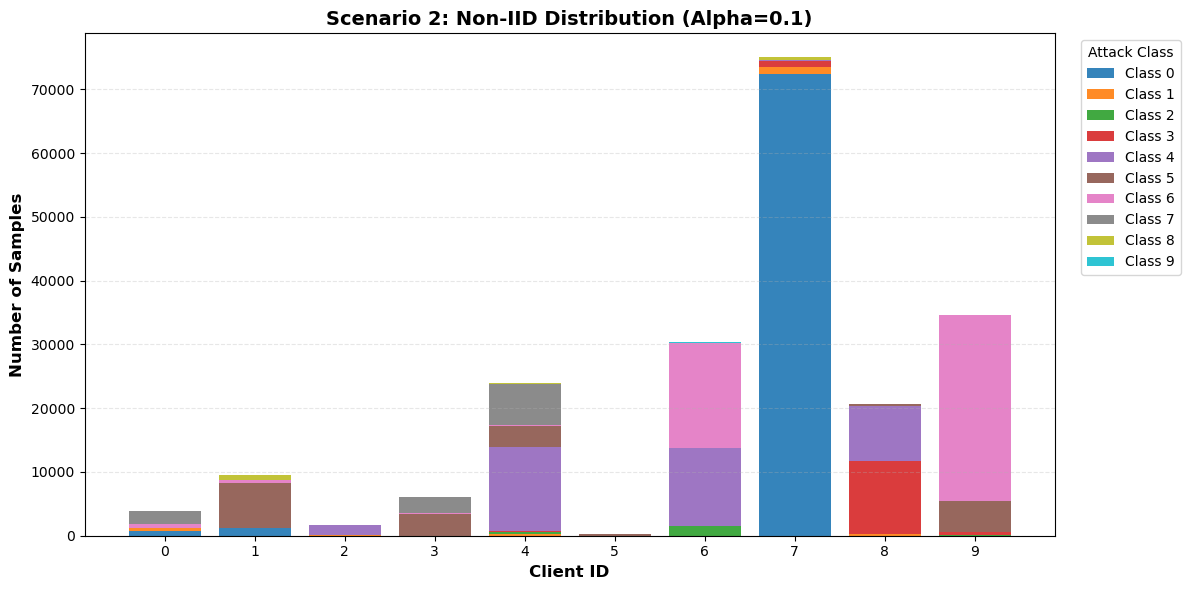

In [4]:
# --- SCENARIO 2: Non-IID (Alpha = 0.1) ---
print("Generating Non-IID Partition (Dirichlet)...")
partitions_skew = partition_data(train_pool, n_clients=10, method="dirichlet", alpha=0.1)

visualize_partition(train_pool, partitions_skew, title="Scenario 2: Non-IID Distribution (Alpha=0.1)")

Generating Pathological Partition (2 Shards/Client)...
🔪 Partitioning 206138 samples for 10 clients (Method: pathological)...


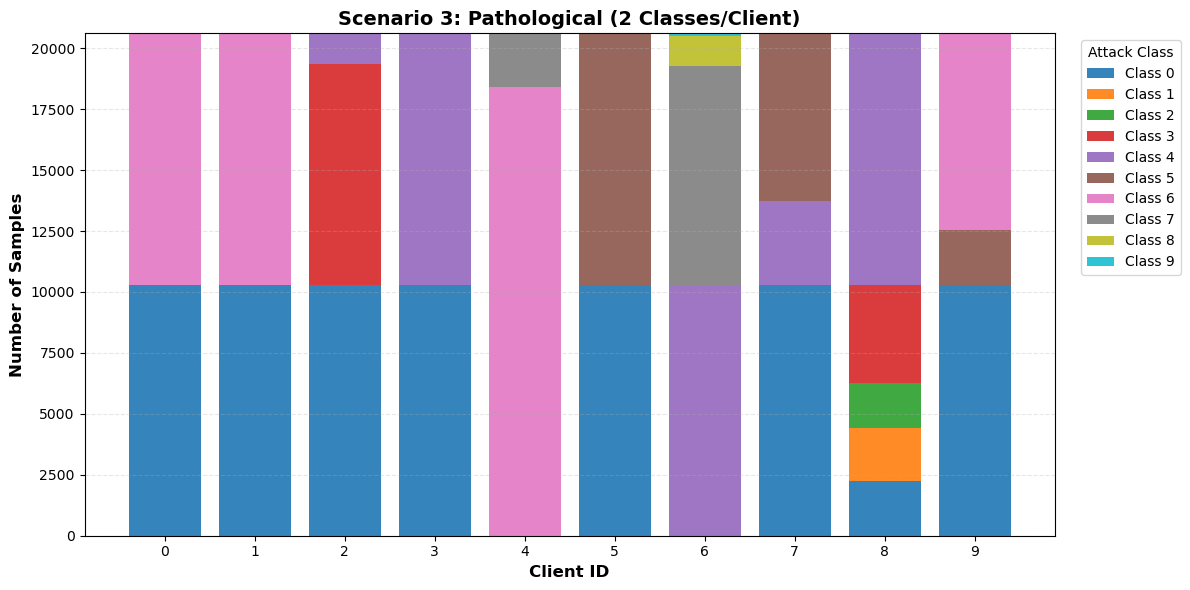

In [ ]:
# --- SCENARIO 3: Pathological (Exact 2 Classes per Client) ---
print("Generating Pathological Partition (2 Shards/Client)...")

partitions_path = partition_data(train_pool, n_clients=10, method="pathological")

visualize_partition(train_pool, partitions_path, title="Scenario 3: Pathological (2 Classes/Client)")